# Image-Based Deep Learning on Air Quality Using A 9-Layer Residual Neural Network

Air pollution continues to negatively impact human health and the environment, causing respiratory and cardiovascular diseases while damaging ecosystems. This project addresses the critical shortage of air quality monitoring systems, which are often outdated, broken, or nonexistent due to high costs, by developing a cost-effective deep learning solution to estimate PM2.5 (particulate matter \<2.5 micrometers) concentrations from natural images.​​

Using a ResNet9 (9-layer Residual Neural Network) model, this research classifies 862 images into three PM2.5 concentration levels: Good (<35.4µg/m³), Unhealthy (35.5~150.4µg/m³), and Hazardous (\>150.5µg/m³). The dataset combines:

*   **456 images from Beijing tourist website archives** (2014-2021), capturing diverse urban environments under varying weather conditions and seasons​
*   **406 images from the National Park Service's Yosemite Turtleback Dome webcam** (2014-2021), representing rural natural landscapes

Each image is paired with corresponding PM2.5 concentration data from the AirNow database, matched by location and timestamp. This geographic diversity enables the model to generalize across different environments, achieving **83% accuracy**, which is significantly outperforming current state-of-the-art CNN models (69%) and Random Forest Classifiers (64%). The model provides an accessible, efficient alternative to expensive monitoring equipment, with potential applications for governmental organizations, researchers, and smartphone users.

## Download the Dataset

This section downloads the combined Beijing and Yosemite National Park image dataset from Kaggle. The dataset contains **862 images** (456 from Beijing, 406 from Yosemite) taken between 2014-2021, each paired with corresponding PM2.5 concentration levels from the AirNow database.

In [1]:
# Install opendatasets library to download from Kaggle
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os
import shutil

In [3]:
# Kaggle dataset URL containing Beijing and Yosemite images
dataset_url = 'https://www.kaggle.com/datasets/amyyang442/airqualityyosemitebeijing'

In [4]:
# Remove existing dataset directory if present to ensure clean download
if os.path.exists('./airqualityyosemitebeijing'):
  shutil.rmtree('./airqualityyosemitebeijing')

In [5]:
# Download dataset from Kaggle (requires Kaggle API credentials)
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: amyyang442
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/amyyang442/airqualityyosemitebeijing


100%|██████████| 13.8M/13.8M [00:00<00:00, 1.32GB/s]

In [6]:
# Set path to downloaded dataset
data_dir = './airqualityyosemitebeijing'

## Data Exploration and Classification Setup

Examine the dataset structure and image distribution across the three PM2.5 concentration classes: **Good** (\<35.4µg/m³), **Unhealthy** (35.5~150.4µg/m³), and **Hazardous** (\>150.5µg/m³).

In [7]:
# Display dataset directory structure
os.listdir(data_dir)

['2unhealthy', '3hazardous', '1goodmoderate']

In [8]:
# Count number of images in each PM2.5 concentration class
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

2unhealthy : 279
3hazardous : 272
1goodmoderate : 311


## Load Dataset into PyTorch

Import the image dataset using PyTorch's ImageFolder class, which automatically assigns labels based on subdirectory names (Good, Unhealthy, Hazardous).

In [9]:
from torchvision.datasets import ImageFolder

In [10]:
# Load dataset with automatic class labeling
dataset = ImageFolder(data_dir)

In [11]:
len(dataset)

862

In [12]:
# Examine first image-label pair
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x213>, 0)

In [13]:
# Display the three PM2.5 concentration classes
dataset.classes

['1goodmoderate', '2unhealthy', '3hazardous']

## Visualize Sample Image

Display a sample image from the dataset to verify proper loading.

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

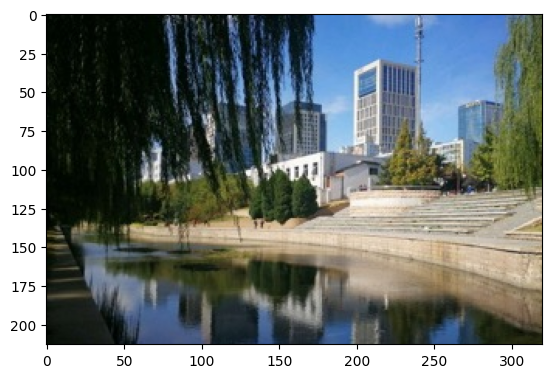

In [15]:
# Extract first image and its label
img, label = dataset[0]
plt.imshow(img)

## Apply Image Transformations

Preprocess images to match ResNet9 input requirements. Original images (320×213 pixels) are resized to 64×64 pixels.

In [16]:
import torchvision.transforms as tt

# Apply transformations: resize to 64x64 and convert to tensor
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                           tt.CenterCrop(64),
                                            tt.ToTensor()]))

## Verify Image Transformations

Display a resized sample image to confirm the 64×64 pixel transformation was applied correctly.

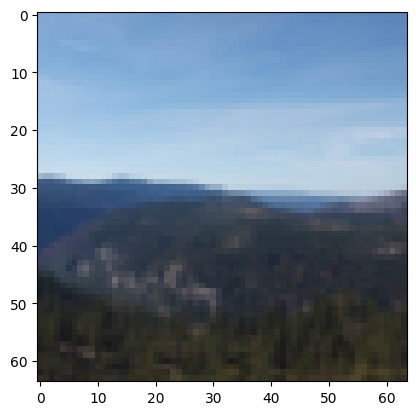

In [17]:
# Display resized image (index 120 from dataset)
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

## Training and Validation Dataset Split

Split the 862 images into training (90%) and validation (10%) sets. This results in 776 training images and 86 validation images for evaluating the ResNet9 model's performance.


In [18]:
# Define validation split percentage
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

print(f"Training size: {train_size}, Validation size: {val_size}")

Training size: 776, Validation size: 86


In [19]:
from torch.utils.data import random_split

# Randomly split dataset into training and validation sets
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
print(f"Train dataset: {len(train_ds)}, Validation dataset: {len(valid_ds)}")

Train dataset: 776, Validation dataset: 86


## Create Data Loaders

Initialize PyTorch DataLoaders with a batch size of 128 images to efficiently load data during training. The training loader shuffles data to improve model generalization, while the validation loader maintains order for consistent evaluation.

In [20]:
from torch.utils.data import DataLoader

# Process 128 images per batch
batch_size = 128

# Training data loader with shuffling
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,       # Randomize order each epoch
                      num_workers = 4,    # Parallel data loading
                      pin_memory=True)    # Speed up GPU transfer

# Validation data loader without shuffling
valid_dl = DataLoader(valid_ds,
                    batch_size,
                    num_workers=4,
                    pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Visualize Training Batch

Display a random batch of 128 images from the training set to verify data loading and observe the variety of PM2.5 concentration levels across different scenes.

In [21]:
from torchvision.utils import make_grid

def show_batch(dl):
  """Display one batch of images in a grid layout"""
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

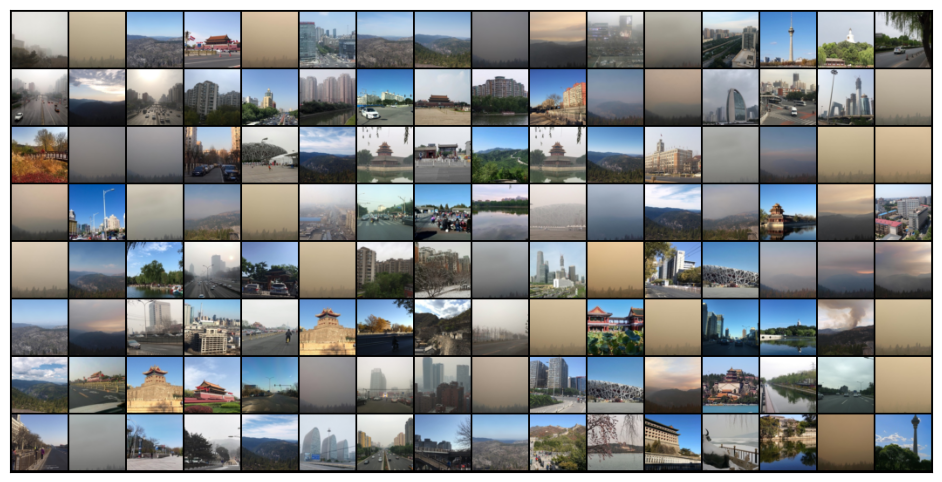

In [22]:
# Show sample batch from training data
show_batch(train_dl)

## GPU Acceleration Setup

Configure PyTorch to use GPU acceleration for training the ResNet9 model. GPU processing significantly speeds up the training of deep neural networks, reducing training time from hours to minutes for the 776 training images.

In [23]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Verify GPU Availability and Initialize Device

Check if CUDA-enabled GPU is available and set the default device for training. This ensures the ResNet9 model and image data are processed on the most efficient hardware available.

In [24]:
# Check if GPU is available
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [25]:
# Set device (GPU if available, otherwise CPU)
device = get_default_device()
print(f"Using device: {device}")

Using device: cuda


## Test GPU Transfer

Verify that tensors can be successfully moved to the GPU by transferring a sample image from the dataset.

In [26]:
# Get sample image and label
img, label = dataset[0]

In [27]:
# Move image tensor to GPU
img_gpu = to_device(img, device)
print(f"Image tensor device: {img_gpu.device}")

Image tensor device: cuda:0


## Move DataLoaders to GPU

Wrap the training and validation DataLoaders to automatically transfer each batch of 128 images to the GPU during training. This ensures efficient memory management and faster processing throughout the ResNet9 training process.

In [28]:
# Wrap dataloaders to automatically move batches to GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model Training Utilities

Define the base class and utility functions for training the ResNet9 model. These include methods for calculating loss and accuracy during training and validation phases.

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        """Calculate cross-entropy loss for a training batch"""
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        """Calculate loss and accuracy for a validation batch"""
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        """Aggregate validation metrics across all batches"""
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        """Print training progress after each epoch"""
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    """Calculate classification accuracy"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluate model performance on validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent optimization"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()         # Compute gradients
            optimizer.step()        # Update weights
            optimizer.zero_grad()   # Reset gradients
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## ResNet9 Architecture

Build the 9-layer Residual Neural Network for classifying PM2.5 concentrations into three classes: **Good** (\<35.4µg/m³), **Unhealthy** (35.5~150.4µg/m³), and **Hazardous** (\>150.5µg/m³).

The architecture includes:
- 4 convolutional blocks with batch normalization and ReLU activation
- 2 residual blocks to combat the vanishing gradient problem
- Max pooling layers for downsampling
- Dropout (0.2) to prevent overfitting
- Adaptive pooling and fully connected layer for classification

In [31]:
def conv_block(in_channels, out_channels, pool=False):
    """Create a convolutional block with batch normalization and ReLU"""
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    # Downsample by factor of 2
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # First two convolutional blocks
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        # Second pair of convolutional blocks
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        # Classification head
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),      # Global max pooling
                                        nn.Flatten(),                 # Flatten to 1D
                                        nn.Dropout(0.2),              # Dropout to prevent overfitting
                                        nn.Linear(512, num_classes))  # Fully connected layer

    def forward(self, xb):
        """Forward pass with residual connections"""
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out      # First residual connection
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out      # Second residual connection
        out = self.classifier(out)
        return out

## Initialize Model

Create ResNet9 instance with 3 input channels (RGB images) and 3 output classes (Good, Unhealthy, Hazardous PM2.5 levels). Move the model to GPU for accelerated training.

In [32]:
# Initialize ResNet9 with 3 RGB channels and 3 PM2.5 classes
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [33]:
# Verify model is on GPU
model.conv1[0].weight.device

device(type='cuda', index=0)

## Test Model Forward Pass

Verify the ResNet9 model processes a batch correctly by passing one batch through the network and examining tensor shapes and device placement.

In [34]:
# Clear GPU cache to free memory
torch.cuda.empty_cache()

# Pass one batch through the model to verify architecture
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)      # Should be [128, 3, 64, 64]
    print('images.device', images.device)    # Should be 'cuda'
    preds = model(images)
    print('preds.shape', preds.shape)        # Should be [128, 3]
    break


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 3])


## Train ResNet9 Model

Train the model using hyperparameters:
- **Stage 1:** 5 epochs with learning rate 0.001
- **Stage 2:** 10 epochs with learning rate 0.0001  
- **Stage 3:** 15 epochs with learning rate 0.00001
- **Optimizer:** Adam (handles noisy/grainy images effectively)

This multi-stage training with decreasing learning rates allows the model to make large adjustments initially, then fine-tune for optimal performance. The model achieved **83% accuracy** on classifying PM2.5 concentration levels.

In [35]:
# Evaluate initial model performance before training
history = [evaluate(model, valid_dl)]
print("Initial validation metrics:", history)

Initial validation metrics: [{'val_loss': 1.0995936393737793, 'val_acc': 0.3488371968269348}]


In [36]:
# Stage 1: Train with learning rate 0.001 for 5 epochs
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.8363, val_loss: 1.3085, val_acc: 0.3721
Epoch [1], train_loss: 0.7658, val_loss: 0.8482, val_acc: 0.5581
Epoch [2], train_loss: 0.6823, val_loss: 0.9292, val_acc: 0.5116
Epoch [3], train_loss: 0.8642, val_loss: 0.9260, val_acc: 0.5000
Epoch [4], train_loss: 0.6391, val_loss: 0.7951, val_acc: 0.5349


In [37]:
# Stage 2: Train with learning rate 0.0001 for 10 epochs
history += fit(10, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.6342, val_loss: 0.6292, val_acc: 0.7093
Epoch [1], train_loss: 0.5064, val_loss: 0.5956, val_acc: 0.6860
Epoch [2], train_loss: 0.5732, val_loss: 0.5465, val_acc: 0.7558
Epoch [3], train_loss: 0.5976, val_loss: 0.4856, val_acc: 0.8488
Epoch [4], train_loss: 0.8217, val_loss: 0.4835, val_acc: 0.8140
Epoch [5], train_loss: 0.5403, val_loss: 0.4772, val_acc: 0.8256
Epoch [6], train_loss: 0.5245, val_loss: 0.4756, val_acc: 0.8256
Epoch [7], train_loss: 0.4995, val_loss: 0.4915, val_acc: 0.8256
Epoch [8], train_loss: 0.4852, val_loss: 0.5599, val_acc: 0.7791
Epoch [9], train_loss: 0.5062, val_loss: 0.6047, val_acc: 0.7558


In [38]:
# Stage 3: Train with learning rate 0.00001 for 15 epochs
history += fit(15, 0.00001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4123, val_loss: 0.5346, val_acc: 0.8140
Epoch [1], train_loss: 0.4832, val_loss: 0.5256, val_acc: 0.8256
Epoch [2], train_loss: 0.5062, val_loss: 0.5414, val_acc: 0.8140
Epoch [3], train_loss: 0.3899, val_loss: 0.4986, val_acc: 0.8488
Epoch [4], train_loss: 0.4668, val_loss: 0.4900, val_acc: 0.8372
Epoch [5], train_loss: 0.4998, val_loss: 0.5120, val_acc: 0.8140
Epoch [6], train_loss: 0.3769, val_loss: 0.5112, val_acc: 0.8256
Epoch [7], train_loss: 0.5037, val_loss: 0.4900, val_acc: 0.8256
Epoch [8], train_loss: 0.5005, val_loss: 0.4828, val_acc: 0.8372
Epoch [9], train_loss: 0.4521, val_loss: 0.5053, val_acc: 0.8023
Epoch [10], train_loss: 0.3833, val_loss: 0.4983, val_acc: 0.8023
Epoch [11], train_loss: 0.4441, val_loss: 0.4973, val_acc: 0.8140
Epoch [12], train_loss: 0.4022, val_loss: 0.5081, val_acc: 0.8140
Epoch [13], train_loss: 0.4490, val_loss: 0.5099, val_acc: 0.8140
Epoch [14], train_loss: 0.4037, val_loss: 0.4886, val_acc: 0.8372


## Visualize Training Results

Plot validation accuracy and training/validation loss over epochs to analyze model performance and detect potential overfitting.

In [39]:
def plot_accuracies(history):
    """Plot validation accuracy over training epochs"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

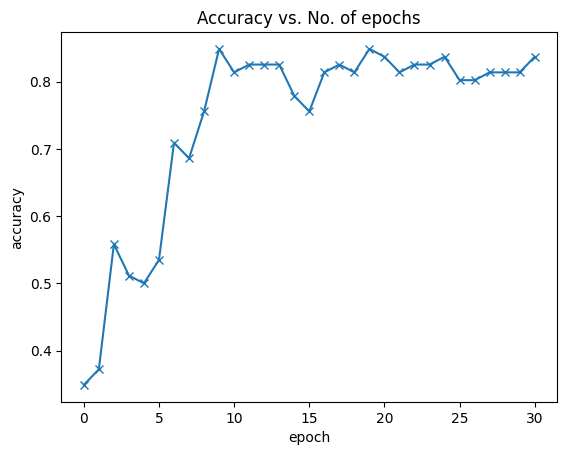

In [40]:
# Display accuracy progression
plot_accuracies(history)

In [41]:
def plot_losses(history):
    """Plot training and validation loss over epochs"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

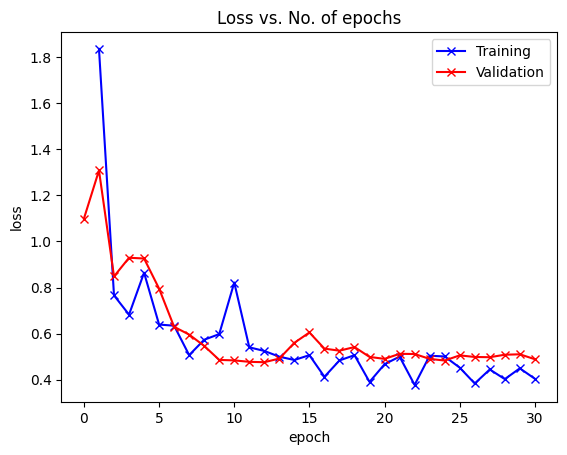

In [42]:
# Display loss progression
plot_losses(history)

## Test Model with Individual Images

Create prediction functions to classify individual images from the validation set into PM2.5 concentration categories: **Good**, **Unhealthy**, or **Hazardous**. This demonstrates the model's practical application for estimating air quality from natural images.

In [43]:
def predict_image(img, model, classes):
    """Predict PM2.5 concentration class for a single image"""
    # Convert to batch of 1 and move to GPU
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [44]:
def show_image_prediction(img, label):
    """Display image with actual and predicted PM2.5 class"""
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: 2unhealthy
Prediction: 2unhealthy


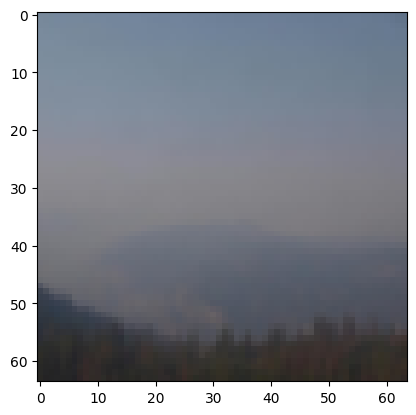

In [45]:
# Test prediction on a validation image
show_image_prediction(*valid_ds[70])

## Save Trained Model

Save the trained ResNet9 model weights for future use and deployment. This enables the model to be loaded later for making PM2.5 predictions on new webcam images without retraining.

In [46]:
# Save model state dictionary to file
torch.save(model.state_dict(), 'airquality-resnet9.pth')
print("Model saved successfully as 'airquality-resnet9.pth'")

Model saved successfully as 'airquality-resnet9.pth'


## Conclusions

### Key Findings

This research successfully demonstrated that the **ResNet9 model is a valid and effective method** for estimating PM2.5 concentration levels from natural images. The model achieved several significant results:

- **83% average accuracy** in classifying images into three PM2.5 concentration classes: Good (\<35.4µg/m³), Unhealthy (35.5~150.4µg/m³), and Hazardous (\>150.5µg/m³)
- **Outperformed existing methods** by a significant margin compared to CNN models (69% accuracy) and Random Forest Classifiers (64% accuracy)
- Successfully classified **862 images** from diverse geographic locations (Beijing and Yosemite National Park) spanning 2014-2021
- Demonstrated the effectiveness of the ResNet9 architecture in combating the vanishing gradient problem, enabling better feature extraction from images with varying air quality levels

### Significance

This ResNet9 model provides a **cost-effective and accessible alternative** to expensive air quality monitoring systems, which are often outdated, broken, or nonexistent in many locations including national parks. The model has potential applications for:

- Governmental organizations monitoring air quality across large geographic regions
- Researchers analyzing air quality trends over time using webcam archives
- Future smartphone applications enabling individuals to estimate real-time PM2.5 levels from photos

### Future Research Directions

To further improve the model's performance and applicability, future work should include:

1. **Expanded datasets** from various geographic regions globally to increase generalization across different environments (urban, rural, coastal, mountainous, etc.)
2. **Incorporation of weather variables** such as precipitation, humidity, and temperature to enable PM2.5 concentration forecasting similar to weather predictions
3. **Testing alternative CNN architectures** beyond ResNet9 to potentially achieve even higher classification accuracy
4. **Real-world deployment** through smartphone applications and integration with existing webcam systems at national parks and urban monitoring stations

The developed ResNet9 model demonstrates that image-based deep learning can significantly improve air quality monitoring accessibility, ultimately benefiting human health and environmental protection efforts worldwide.